In [1]:
#To autoreload a function if it is changed
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import anndata
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import re



from utils import plot_histogram
from var import sc_data_folder, results_folder, today, color

In [3]:
#set seed to 1 for reproducibility of results
np.random.seed(0)

In [4]:
#Create figures folder
figures_folder = os.path.join(results_folder, 'figures/rna_exploration/')
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

<h3> 1. Load .h5ad and mapping file </h3>

In [7]:
def read_10x_output(file_path, smp_list, metadata=None, type = 'raw', umi_filter=5):
    import os
    
    #Writing output from separate samples, processed using CellRanger, into a dictionary of Scanpy objects:
    ad = {}

    #Generate AnnData for each sample
    for sample_name in smp_list:
        path = file_path + sample_name
        for i in os.listdir(path):
            #filter for raw and filtered files
            if i==f'{type}_feature_bc_matrix':
                mtx_folder = i
        #read in matrix, features and barcodes
        mtx_folder_path = f'{file_path}{sample_name}/{mtx_folder}/'
        adata_init = sc.read_mtx(f'{mtx_folder_path}matrix.mtx.gz')
        #data wrangling for features_df to have the same format and column headers as if it is read with sc.read_10x_h5()
        features_df = features_df = pd.read_csv(f'{mtx_folder_path}features.tsv.gz', sep='\t', header=None, names=['gene_ids', 'gene_names', 'feature_types', 'genome'])
        features_df = features_df.set_index('gene_names')
        features_df['genome'] = 'GRCh38'
        
        barcodes_df = pd.read_csv(f'{mtx_folder_path}barcodes.tsv.gz', sep='\t', header=None, names=['barcodes'])
        
        #check if count matrix needs to be transposed
        if adata_init.shape[0] == features_df.shape[0]:
            #transpose the matrix to correct for dimensionality 
            adata = anndata.AnnData(X=adata_init.X.T.copy(), obs=barcodes_df, var=features_df)
        else:
            adata = anndata.AnnData(X=adata_init.X.copy(), obs=barcodes_df, var=features_df)
        ad[sample_name] = adata
        ad[sample_name].var.rename(columns = {'gene_ids':'ENSEMBL'}, inplace = True)
        ad[sample_name].var['SYMBOL'] = ad[sample_name].var.index
        ad[sample_name].var.index = ad[sample_name].var['ENSEMBL']
        ad[sample_name].var.drop(columns=['ENSEMBL'], inplace=True)
        #ad[sample_name].var_names_make_unique() 
        
        
        sc.pp.calculate_qc_metrics(ad[sample_name], inplace=True)
        ad[sample_name] = ad[sample_name][ad[sample_name].obs['total_counts'] > umi_filter, :]
        ad[sample_name].var['mt'] = [gene.startswith('mt-') 
                                     for gene in ad[sample_name].var['SYMBOL'].str.lower()]
        ad[sample_name].obs['mt_frac'] = (ad[sample_name][:, 
               ad[sample_name].var['mt'].tolist()].X.sum(1).A.squeeze() 
                                          / ad[sample_name].obs['total_counts'])
        
        ad[sample_name].obs['sample'] = sample_name
        ad[sample_name].obs['barcode'] = ad[sample_name].obs_names
        ad[sample_name].obs_names = ad[sample_name].obs['sample']+"_"+ad[sample_name].obs['barcode']

    #Merge AnnData objects from all the samples together    
    from scipy.sparse import vstack
    stack = vstack([ad[x].X for x in smp_list]) # stack data
    adata = sc.AnnData(stack, var = ad[smp_list[0]].var)
    adata.obs = pd.concat([ad[x].obs for x in smp_list], axis = 0)

    if metadata is not None:
        #Add cleaned metadata to the Anndata.obs table
        obs_merged = pd.merge(left = adata.obs, right = metadata, 
                              how = "left", left_on="sample", right_on="sample")
        obs_merged.index = obs_merged['sample']+"_"+obs_merged['barcode']
        print(obs_merged.index.equals(adata.obs.index))
        adata.obs = obs_merged

    return adata, ad


In [5]:
#Create a sample list in form of a dataframe to be concatenated by the read_10x_output function
sample_list = pd.DataFrame({
    'sample': ['cellranger710_count_05e682d5679826b9b76d6bec731bbe61']
})

In [6]:
# #Initial data load

# #Read in 10x data in raw and filtered format
# adata_raw, ad_list = read_10x_output(
#     sc_data_folder, 
#     smp_list=sample_list['sample'],
#     metadata=sample_list, type = 'raw')
# # export aggregated and pre-processed data
# adata_raw.write(f'{results_folder}{today}_all_cells_with_empty.h5ad')

# adata, ad_list = read_10x_output(
#     sc_data_folder, 
#     smp_list=sample_list['sample'],
#     metadata=sample_list, type = 'filtered')
# # export aggregated and pre-processed data
# adata.write(f'{results_folder}{today}_all_cells.h5ad')

NameError: name 'read_10x_output' is not defined

In [9]:
#Read in pre-processed data
adata = sc.read(f'{results_folder}20230113_all_cells.h5ad')

In [7]:
#Read in sgRNA sequences to count reads per guide
sgrna_df=pd.read_csv(f'{sc_data_folder}cellranger710_count_05e682d5679826b9b76d6bec731bbe61/feature_reference.csv')
#Append additional sgRNA sequences that were not included in the data by appending rows to the dataframe
sgrna_rest_df = pd.DataFrame(
    [[
        "sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_2",
        "sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_2",
        "R2",
        "TGCTGTTTCCAGCATAGCTCTTAAAC(BC)",
        "AGTCGCGATCGAACACTCGC",
        "CRISPR Guide Capture"
        ],
    [
        "sgRNA6_SCP_GCAGACGTGCCTACGGACCG_sgRNA6_SCP_GCAGACGTGCCTACGGACCG_2",
        "sgRNA6_SCP_GCAGACGTGCCTACGGACCG_sgRNA6_SCP_GCAGACGTGCCTACGGACCG_2",
        "R2",
        "TGCTGTTTCCAGCATAGCTCTTAAAC(BC)",
        "CGGTCCGTAGGCACGTCTGC",
        "CRISPR Guide Capture"]],
    columns= sgrna_df.columns
)
#rowwise concatenation of the two dataframes
sgrna_df = pd.concat([sgrna_df, sgrna_rest_df], axis=0,ignore_index=True)

<h3> 2. Data exploration by visualisation</h3>

<h4> 2.1 Exploration of .h5ad file</h4>

In [10]:
def subset_cells(
    adata,
    cells_per_category=10000,
    stratify_category_key='sample',
):
    
    adata.obs['_cell_index'] = np.arange(adata.n_obs)
    subset_ind = list()
    
    for ct in adata.obs[stratify_category_key].unique():
        ind = adata.obs[stratify_category_key] == ct
        subset_ind_ = adata.obs['_cell_index'][ind]
        n_samples = np.min((len(subset_ind_), cells_per_category))
        subset_ind = subset_ind + list(np.random.choice(subset_ind_, size=n_samples, replace=False))
    print(len(subset_ind))
    
    return adata[subset_ind, :].copy()

def compute_pcs_knn_umap(
    adata_subset, stratify_category_key='sample', 
    tech_category_key=None, plot_category_keys=list(), 
    scale_max_value=10, n_comps=100, n_neighbors=15,
):
    adata_subset.obs['total_counts'] = np.array(adata_subset.X.sum(1)).flatten()
    adata_subset.layers['counts'] = adata_subset.X.copy()
    # No normalisation by total count
    #does not normalise data effectively
    #proportionality errors if divide by total counts
    sc.pp.log1p(adata_subset)
    # Scale with no HVG selection
    if tech_category_key is None:
        sc.pp.scale(adata_subset, max_value=scale_max_value)
    else:
        for tech in adata_subset.obs[tech_category_key].unique():
            mu, std = compute_mu_std(adata_subset[adata_subset.obs[tech_category_key] == tech].X)
            adata_subset[adata_subset.obs[tech_category_key] == tech].X = (
                np.minimum((adata_subset[adata_subset.obs[tech_category_key] == tech].X - mu) / std, scale_max_value)
            )
    # A lot of PC dimensions
    sc.tl.pca(adata_subset, svd_solver='arpack', n_comps=n_comps, use_highly_variable=False)
    # Plot PCs to confirm that PC1 is indeed linked to total count
    # sc.pl.pca(adata_subset, color=['total_counts'],
    #           components=['1,2', '2,3', '4,5'],
    #           color_map = 'RdPu', ncols = 3, legend_loc='on data',
    #           legend_fontsize=10)
    plt.hist2d(adata_subset.obsm['X_pca'][:, 0].flatten(),
               adata_subset.obs['total_counts'].values.flatten(),
               bins=200,
               norm=mpl.colors.LogNorm());
    plt.xlabel('PC 1');
    plt.ylabel('Total RNA count');
    plt.show()
    plt.savefig(f'{figures_folder}{today}_hist2d.pdf')

    # Remove PC1 to remove technical variability
    adata_subset.obsm['X_pca'] = adata_subset.obsm['X_pca'][:, 1:]
    adata_subset.varm['PCs'] = adata_subset.varm['PCs'][:, 1:]

    # compute KNN and UMAP to see how well this represents the dataset
    sc.pp.neighbors(adata_subset, n_neighbors=n_neighbors)
    sc.tl.umap(adata_subset, min_dist = 0.4, spread = 1.5)

    # Plot UMAP
    sc.pl.umap(adata_subset, color=[stratify_category_key],
               color_map = 'RdPu', ncols = 3, #legend_loc='on data',
               legend_fontsize=10)
    plt.savefig(f'{figures_folder}{today}_sample_umap.pdf')
    return adata_subset

def compute_mu_std(X):
        
    mu = np.array(X.mean(0))
    mu_sq = mu ** 2
    X = X.copy()
    X.data = X.data ** 2
    sq_mu = np.array(X.mean(0))
    std = np.sqrt(sq_mu - mu_sq) + 1e-8
    
    return mu, std

In [11]:
cells_per_category=20000
stratify_category_key='sample'
tech_category_key=None


adata_subset = subset_cells(
    adata, cells_per_category=cells_per_category, 
    stratify_category_key=stratify_category_key,
)

12797


Global seed set to 0
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


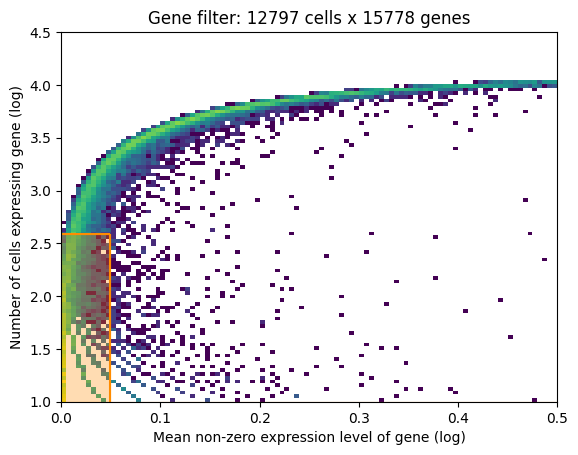

In [12]:
# select informative genes but keep all barcodes
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_subset, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
plt.show()

#select all guides by selecting the names which do not start with ENSG in var_names
targeted_tf_guides = list(adata_subset.var_names[~adata_subset.var_names.str.startswith('ENSG')])
#use list comprehension to split targeted_tf_guides by '_' and select the first element of the list
targeted_tf = [x.split('_')[0] for x in targeted_tf_guides]
targeted_tf_ensembl = list(adata_subset.var_names[adata_subset.var['SYMBOL'].isin(targeted_tf).values])
adata_subset = adata_subset[:, np.unique(list(selected) + targeted_tf_guides + targeted_tf_ensembl)].copy()

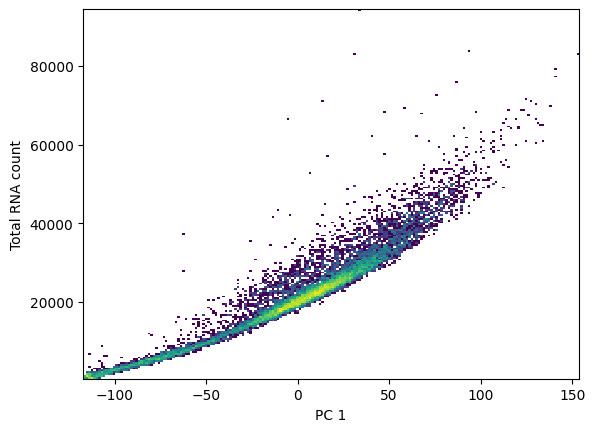

/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 640x480 with 0 Axes>

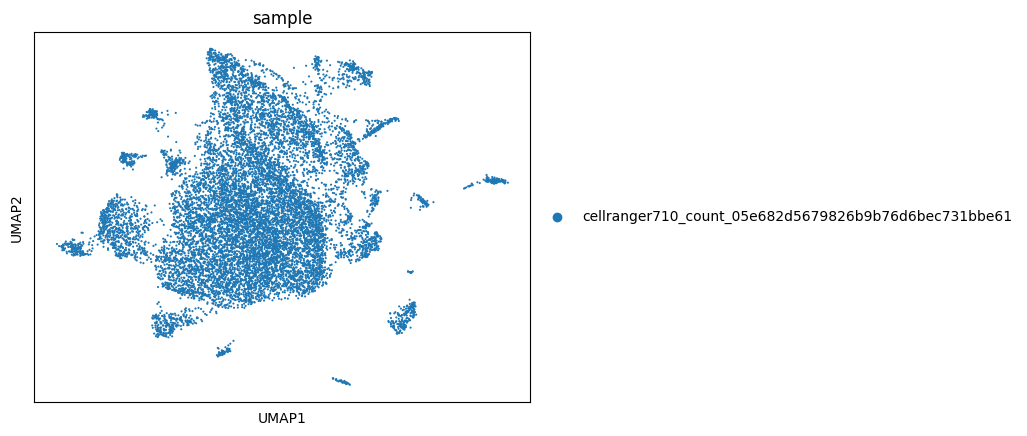

<Figure size 640x480 with 0 Axes>

In [13]:
### Step 1.1 - compute PCs by apply standard workflow with a few exceptions ##
adata_subset = compute_pcs_knn_umap(
    adata_subset, 
    tech_category_key=None, plot_category_keys=None, 
    scale_max_value=10, n_comps=50, n_neighbors=15,
)

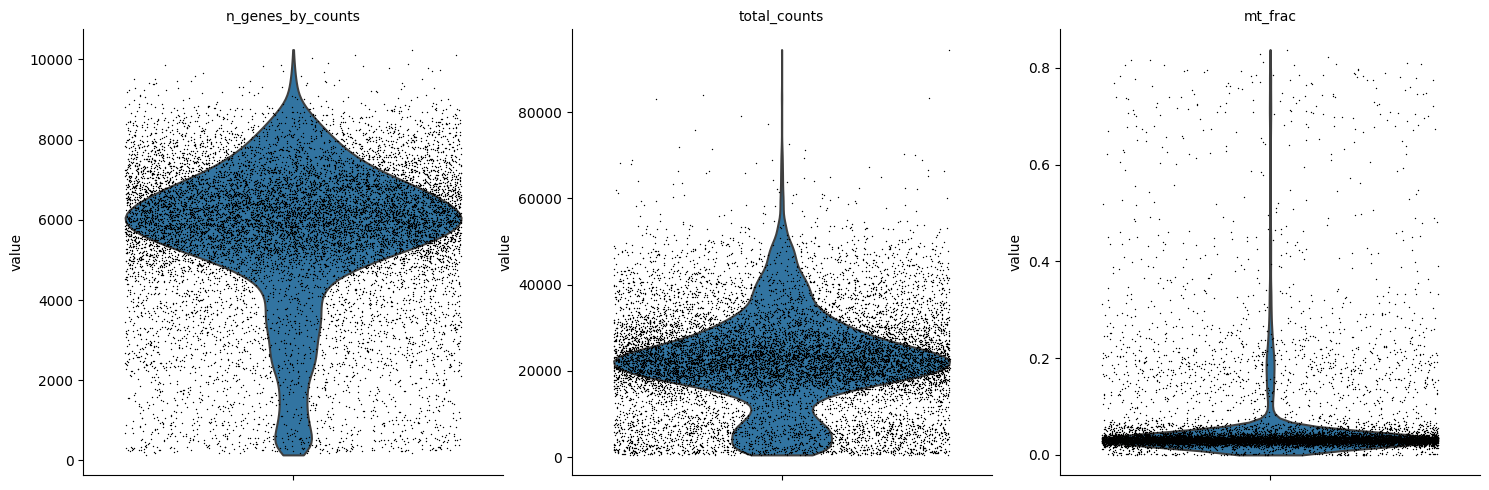

<Figure size 640x480 with 0 Axes>

In [15]:
# Plot violin plots for QC metrics
sc.pl.violin(adata_subset, ['n_genes_by_counts', 'total_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)
plt.savefig(f'{figures_folder}{today}_QC_violin.pdf')

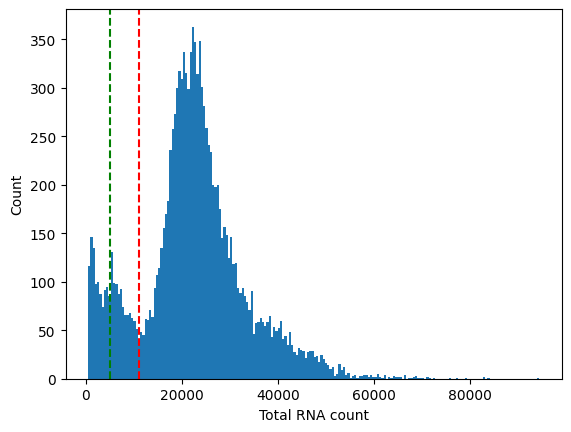

In [55]:


plt.hist(adata_subset.obs['total_counts'],bins=200);
plt.xlabel('Total RNA count');
plt.ylabel('Count');

plt.axvline(x=11000, color='r', linestyle='--')
plt.show()
plt.savefig(f'{figures_folder}{today}_total_rna_count_threshold.pdf', bbox_inches='tight')

In [26]:
adata.obs

,barcodes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,mt_frac,sample,barcode,_cell_index
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_0,AAACCTGAGAATCTCC-1,6041,8.706490,19786.0,9.892780,20.110179,27.944001,36.783584,49.307591,0.053068,cellranger710_count_05e682d5679826b9b76d6bec73...,0,0
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_1,AAACCTGAGAGTACCG-1,8314,9.025816,48614.0,10.791687,21.220225,30.692805,40.000823,52.879829,0.033529,cellranger710_count_05e682d5679826b9b76d6bec73...,1,1
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_2,AAACCTGAGCTAGTTC-1,5989,8.697847,30140.0,10.313642,24.435965,34.903782,44.970139,58.981420,0.030425,cellranger710_count_05e682d5679826b9b76d6bec73...,2,2
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_3,AAACCTGAGTGGTAGC-1,7251,8.889033,33869.0,10.430285,19.362839,28.126015,37.275975,50.110721,0.023650,cellranger710_count_05e682d5679826b9b76d6bec73...,3,3
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_4,AAACCTGCACGGATAG-1,6815,8.827028,34952.0,10.461760,29.620623,38.475624,46.884298,58.566033,0.028410,cellranger710_count_05e682d5679826b9b76d6bec73...,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_12792,TTTGTCAGTTTGTTGG-1,6655,8.803274,23493.0,10.064501,20.091091,28.042396,36.287405,48.452731,0.036819,cellranger710_count_05e682d5679826b9b76d6bec73...,12792,12792
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_12793,TTTGTCATCACCTCGT-1,5849,8.674197,19053.0,9.855032,20.248780,28.819608,37.337952,49.955388,0.034693,cellranger710_count_05e682d5679826b9b76d6bec73...,12793,12793
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_12794,TTTGTCATCTACCAGA-1,5012,8.519790,17361.0,9.762039,23.806232,33.477334,42.785554,55.797477,0.034848,cellranger710_count_05e682d5679826b9b76d6bec73...,12794,12794
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_12795,TTTGTCATCTATGTGG-1,5949,8.691146,18345.0,9.817167,21.253748,28.645407,36.369583,48.470973,0.019733,cellranger710_count_05e682d5679826b9b76d6bec73...,12795,12795


In [29]:
# categorise based on total read counts
adata_subset.obs['total_counts']<5000

cellranger710_count_05e682d5679826b9b76d6bec731bbe61_7842     False
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_4697     False
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_760      False
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_12294    False
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_9670     False
                                                              ...  
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_4859     False
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_3264     False
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_9845     False
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_10799    False
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_2732      True
Name: total_counts, Length: 12797, dtype: bool

In [52]:
#assign three categories to new column 'total_counts_cutoff' based on three threshold ([0,5000],[5000,15000],[1500,]) of total_counts column using vector format
adata_subset.obs['total_counts_cutoff'] = pd.cut(adata_subset.obs['total_counts'], bins=[0,5000,11000,100000], labels=['<5000','5000<x<11000','>11000'])


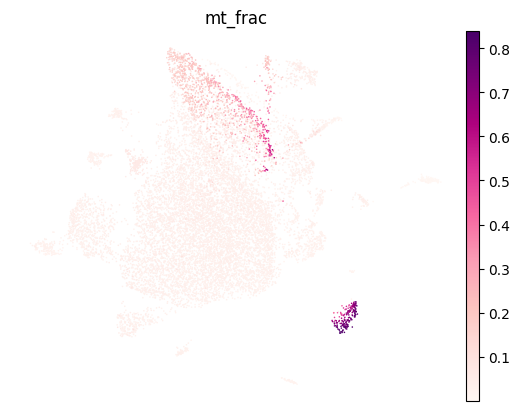

<Figure size 640x480 with 0 Axes>

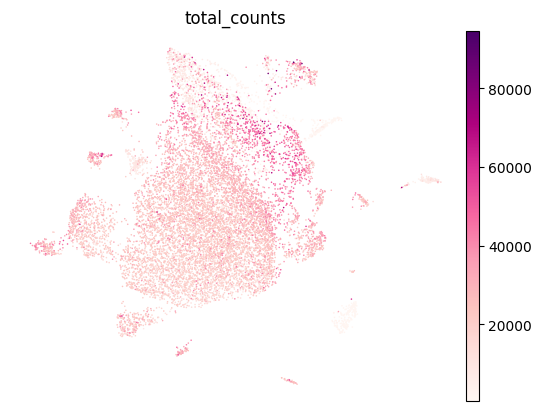

/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 640x480 with 0 Axes>

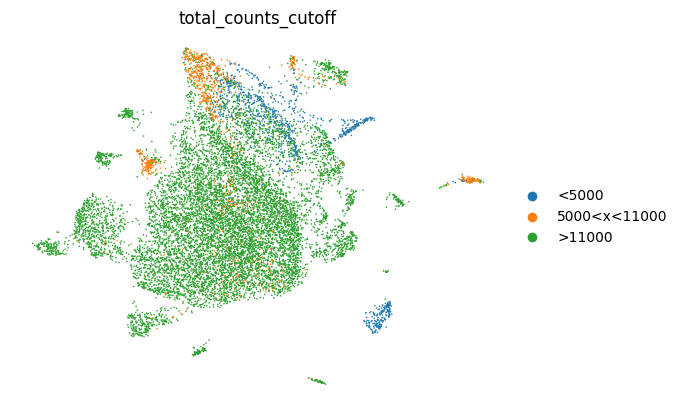

<Figure size 640x480 with 0 Axes>

In [53]:
# Plot QC UMAP without frame
sc.pl.umap(
    adata_subset, color='mt_frac',
    color_map = 'RdPu', ncols = 3, #legend_loc='on data',
    size=5,
    legend_fontsize=10,
    frameon=False
    )
plt.savefig(f'{figures_folder}{today}_mt_frac_umap.pdf')
sc.pl.umap(
    adata_subset, color='total_counts',
    color_map = 'RdPu', ncols = 3, #legend_loc='on data',
    size=5,
    legend_fontsize=10,
    frameon=False
    )

plt.savefig(f'{figures_folder}{today}_total_counts_umap.pdf')

sc.pl.umap(
    adata_subset, color='total_counts_cutoff',
    color_map = 'RdPu', ncols = 3, #legend_loc='on data',
    size=5,
    legend_fontsize=10,
    frameon=False
    )

plt.savefig(f'{figures_folder}{today}_total_counts_cutoff_umap.pdf')


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


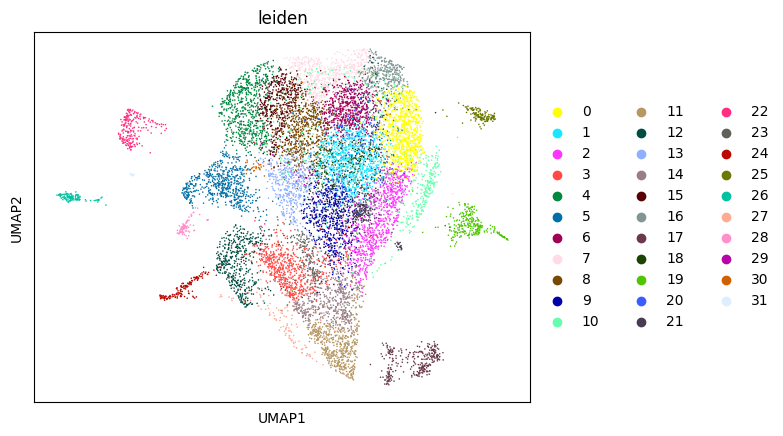

<Figure size 640x480 with 0 Axes>

In [35]:
# Leiden clustering
sc.tl.leiden(adata_subset, resolution=2)
# Plot UMAP
sc.pl.umap(adata_subset, color=['leiden'],
           color_map = 'RdPu', ncols = 3, #legend_loc='on data',
           size=5,
           legend_fontsize=10)
plt.savefig(f'{figures_folder}{today}_leiden_res_2.pdf')

In [35]:
ipsc_tf = ['SOX2', 'KLF4', 'POU5F1', 'NANOG']
cell_cycle = ['MKI67', 'PCNA']
targeted_tf_guides, targeted_tf, ipsc_tf, cell_cycle

(['AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAGAGCGA_1',
  'AIRE_ATCACAGGGAAGTGTCCCTG_AIRE_CAGGGAAGTGTCCCTGCGGG_1',
  'ASCL1_AGCCGCTCGCTGCAGCAGCG_ASCL1_GGAGGGGGAGTTTAGGGAGT_1',
  'ASCL1_CTCCCCGCTGCTGCAGCGAG_ASCL1_GCAGCCGCTCGCTGCAGCAG_1',
  'DBX2_CCGTCCAGATCTGCATAGAG_DBX2_GTCCAGATCTGCATAGAGAG_1',
  'DBX2_GCTCCCAGAGCCTACGCTGT_DBX2_GTTTCTCTGGCCGACAGCGT_1',
  'DLX1_GTGTGGATGCGTCTTACCCG_DLX1_TAAGACGCATCCACACTTCC_1',
  'DLX1_AAAGCTTTGAACCGAGTTTG_DLX1_CCAGTGATTATGCAAGACAG_1',
  'DLX5_ACAAAGCATTGCTTAAAAAG_DLX5_GGGTGTTACTGTTGCTCCCG_1',
  'DLX5_CAAAGCATTGCTTAAAAAGG_DLX5_AAAACTAGTTGGACGAGTTA_1',
  'FOXN1_CCGGAGGGGCTGCGCCAAAA_FOXN1_TAAGAAGCTAGTTTGCTCCT_1',
  'FOXN1_GGAGGGGCTGCGCCAAAACG_FOXN1_CGGAGGGGCTGCGCCAAAAC_1',
  'GATA2_GATCCCGGAGTGTTCGCAAG_GATA2_TTGGGCTTCTTAGGCGTGCG_1',
  'GATA2_ATCCCGGAGTGTTCGCAAGA_GATA2_CCTGCACAGACATGAAGCGG_1',
  'IRF3_CCGCCCTTTCTACGCTGGGC_IRF3_GTTTCCGGCCAGAGGCATGC_1',
  'IRF3_CCGGCCCAGCGTAGAAAGGG_IRF3_TAACCGGCCCAGCGTAGAAA_1',
  'LHX6_ATGACTCATCTTGAACCGAG_LHX6_TCCCCCTCCA

In [36]:
expected_tfs = [
'AIRE',
'ASCL1',
'DBX2',
'DLX1',
'DLX5',
'FOXN1',
'GATA2',
'IRF3',
'LHX6',
'MAFB',
'MYOD1',
'NEUROD2',
'NEUROG2',
'OLIG1',
'OLIG2',
'PROX1',
'RORA',
'RORB',
'SATB2',
]

[i for i in expected_tfs if i not in targeted_tf]

[]

In [39]:
len(np.unique(targeted_tf)), len(expected_tfs)

(23, 19)

In [ ]:
pd.Series(
    np.array(adata_subset[targeted_tfs_barcodes].layers['counts'].sum(0)).flatten(),
    index=targeted_tf_barcodes
)

In [48]:
adata_subset[:, targeted_tf_guides]

View of AnnData object with n_obs × n_vars = 12797 × 1
    obs: 'barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', '_cell_index'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [39]:
sample = adata_subset.obs['sample'].isin(["cellranger710_count_05e682d5679826b9b76d6bec731bbe61"])

In [42]:
adata_subset[sample]

View of AnnData object with n_obs × n_vars = 12797 × 15735
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', '_cell_index'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean'

In [43]:
targeted_tf_barcodes = [i for i in adata_subset.var_names if 'BARCODE' in i]

/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


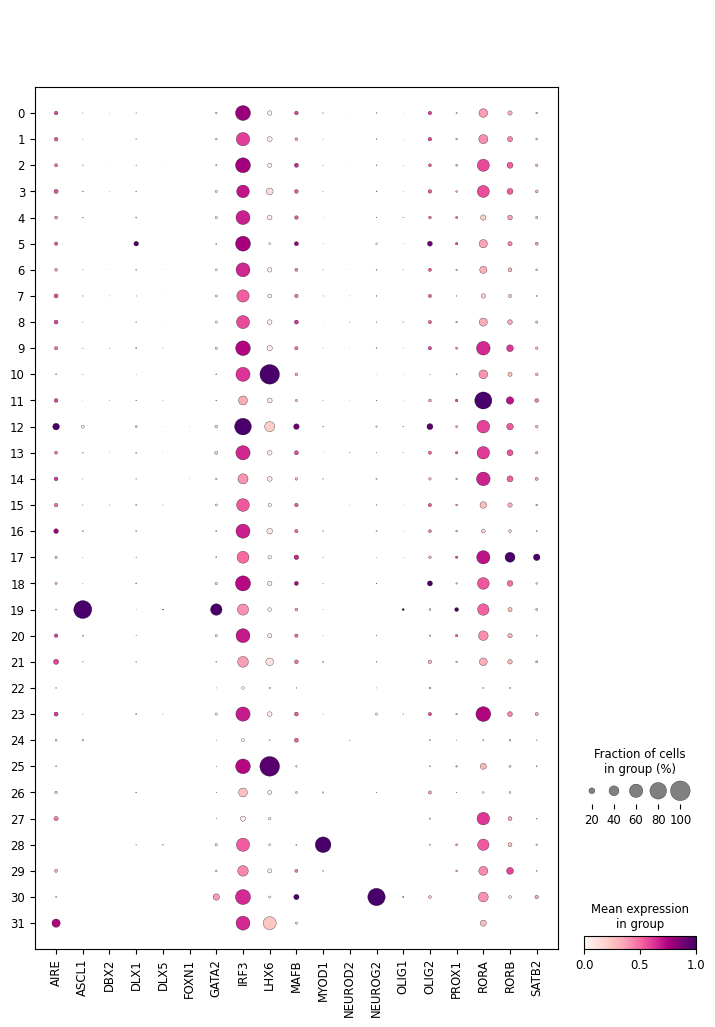

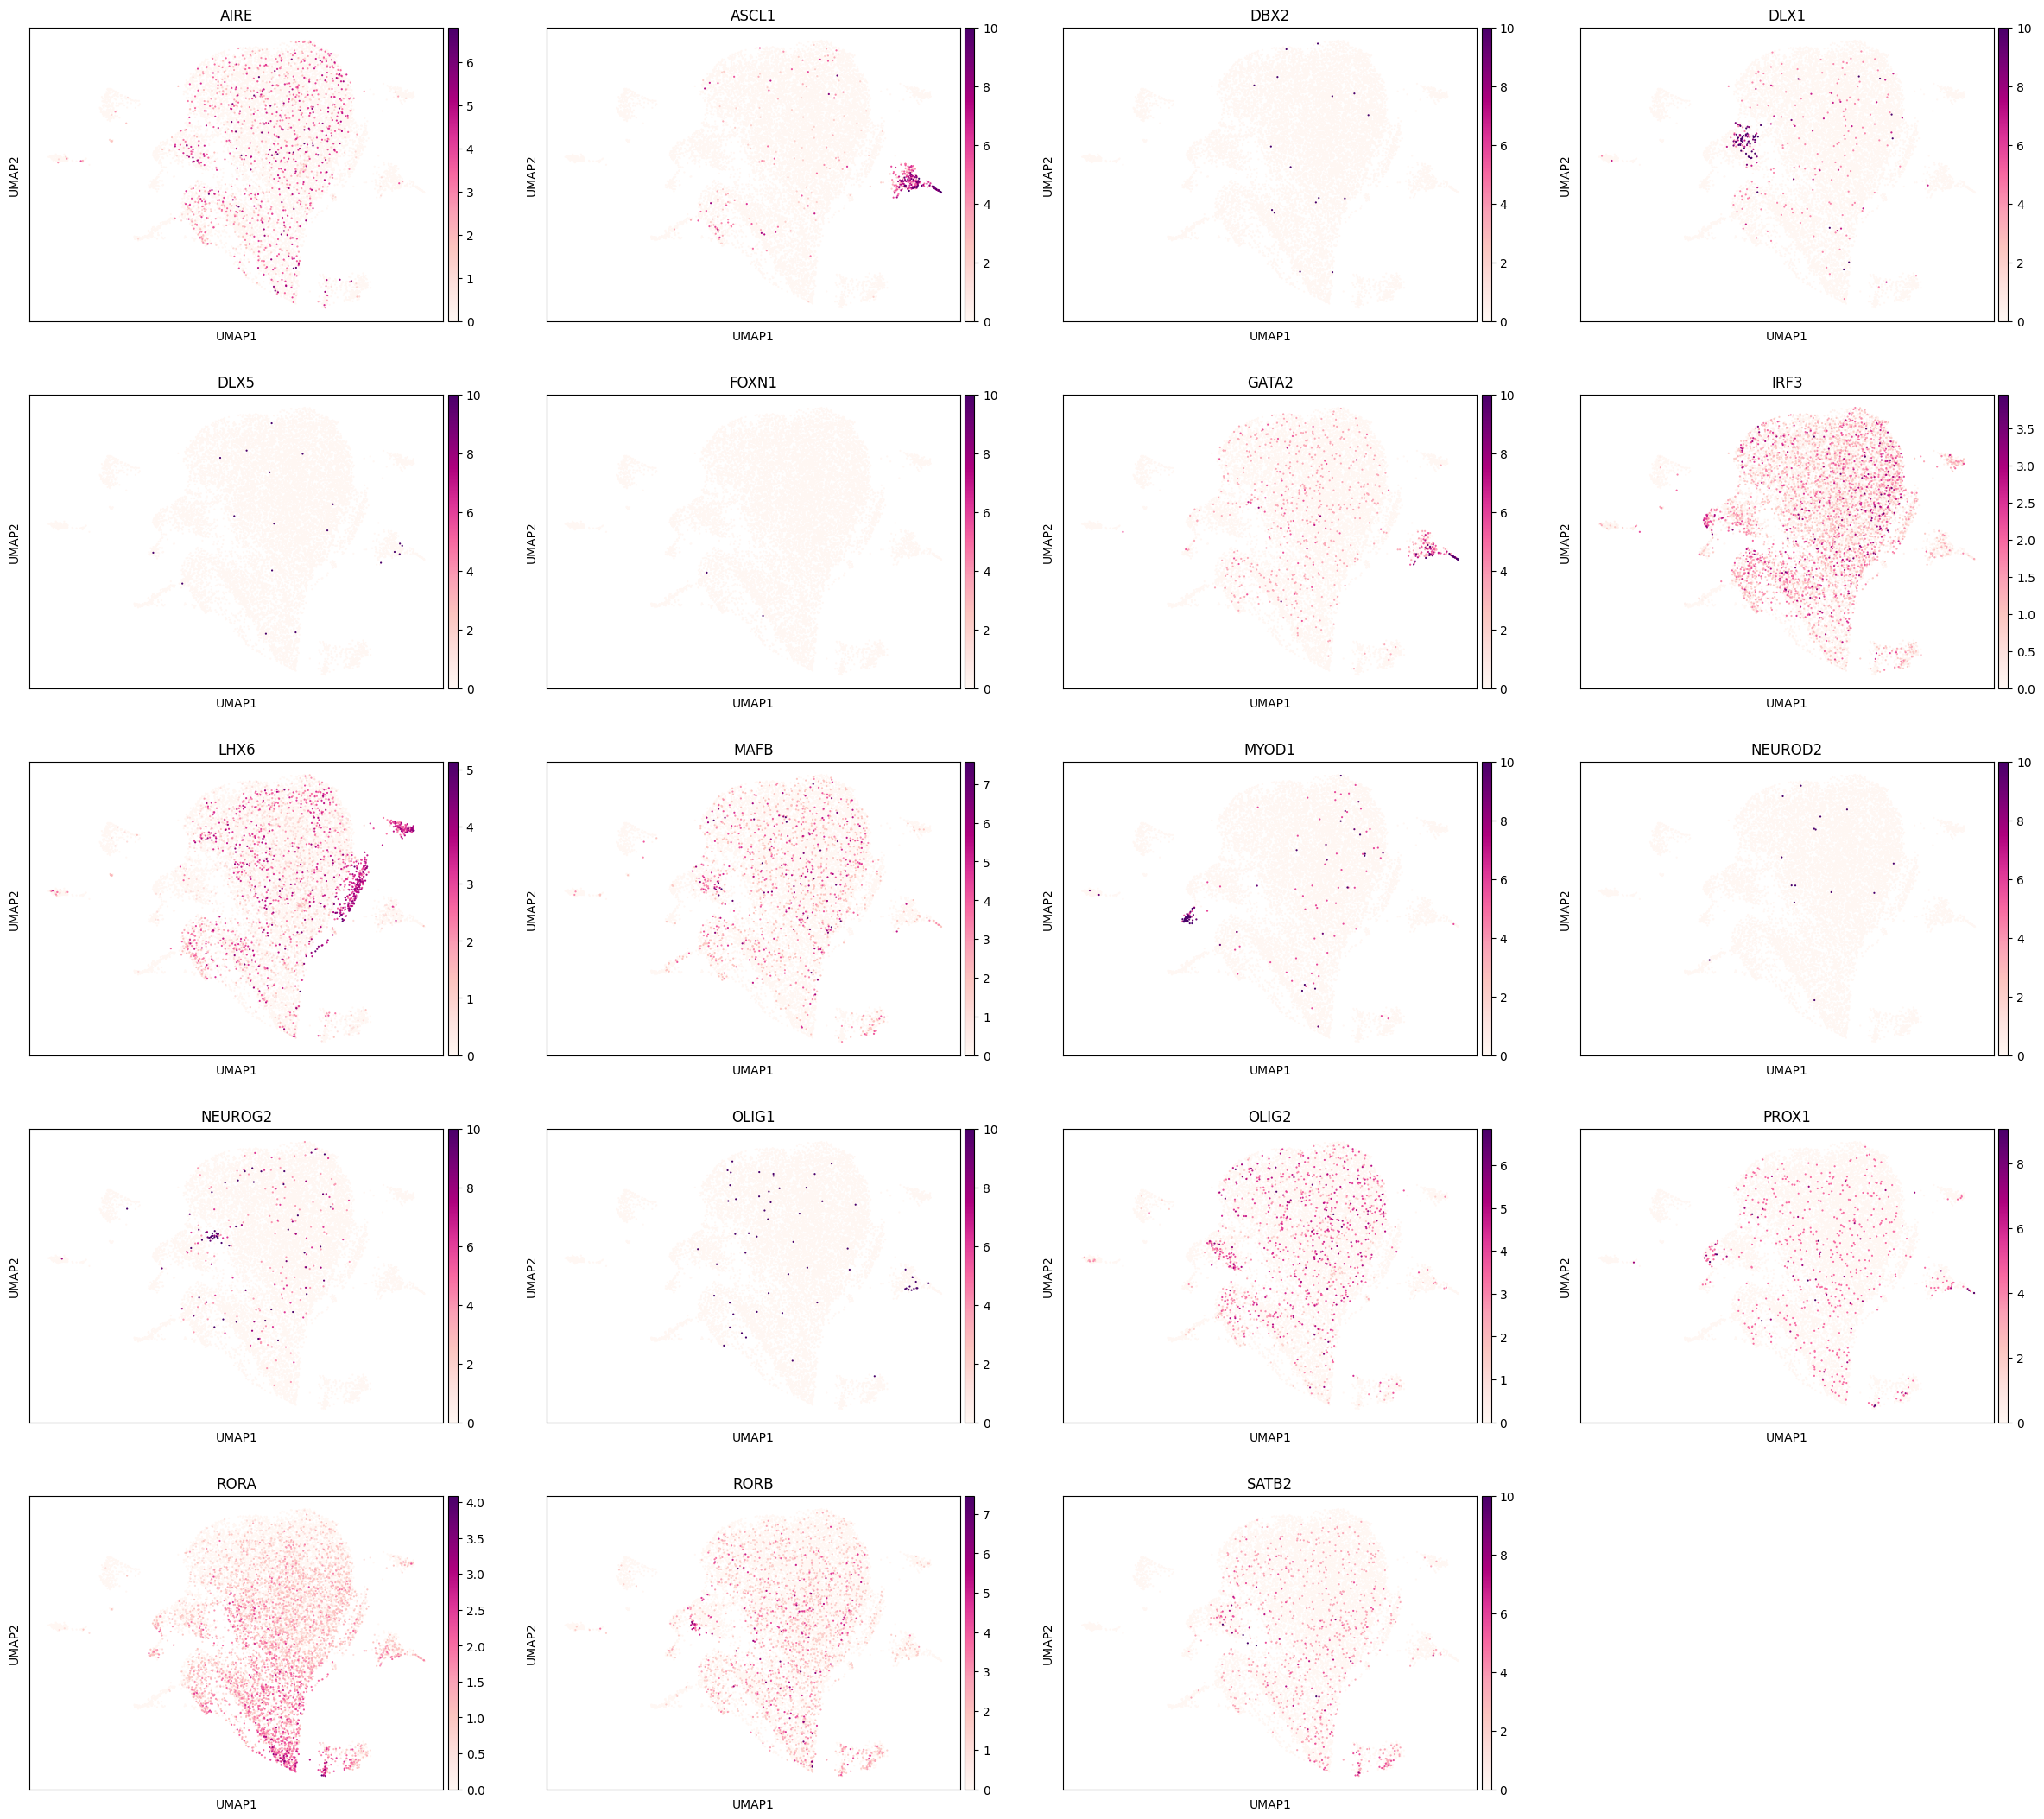

In [41]:
sc.pl.dotplot(adata_subset, expected_tfs, 
              standard_scale='var',
              groupby='leiden', color_map = 'RdPu', gene_symbols='SYMBOL')

sc.pl.umap(adata_subset, color=expected_tfs,
           color_map='RdPu', ncols=4, #legend_loc='on data',
           vmin=0, vmax='p99.999', size=10,
           legend_fontsize=10, gene_symbols='SYMBOL')

In [44]:
adata.var.tail(60)

,feature_types,genome,SYMBOL,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,mt
ENSEMBL,,,,,,,,,,
ENSG00000226906,Gene Expression,GRCh38,TTTY4,0,0.000000,0.000000,100.000000,0.0,0.000000,False
ENSG00000183753,Gene Expression,GRCh38,BPY2,0,0.000000,0.000000,100.000000,0.0,0.000000,False
ENSG00000188120,Gene Expression,GRCh38,DAZ1,0,0.000000,0.000000,100.000000,0.0,0.000000,False
ENSG00000205944,Gene Expression,GRCh38,DAZ2,0,0.000000,0.000000,100.000000,0.0,0.000000,False
ENSG00000169763,Gene Expression,GRCh38,PRYP3,0,0.000000,0.000000,100.000000,0.0,0.000000,False
ENSG00000280961,Gene Expression,GRCh38,TTTY3B,0,0.000000,0.000000,100.000000,0.0,0.000000,False
ENSG00000172352,Gene Expression,GRCh38,CDY1B,0,0.000000,0.000000,100.000000,0.0,0.000000,False
ENSG00000227439,Gene Expression,GRCh38,TTTY17B,0,0.000000,0.000000,100.000000,0.0,0.000000,False
ENSG00000235412,Gene Expression,GRCh38,TTTY4B,0,0.000000,0.000000,100.000000,0.0,0.000000,False


In [ ]:
#compare to clean ipsc data 